<h1> BERT: <i><b>B</b>idirectional <b>E</b>ncoder <b>R</b>epresentations from <b>T</b>ransformers</i></h1>
<h6><i>created by Google AI Language Team in 2018</i></h6>
BERT is designed to pre-train deep bidirectional representations from unlabelled text by jointly conditioning on both left and right context all the layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.
BERT is trained on unlabelled dataset to achieve state of the art results on 11 individual NLP tasks. And all of this with little fine tuning.

![alt text](https://1.bp.blogspot.com/-RLAbr6kPNUo/W9is5FwUXmI/AAAAAAAADeU/5y9466Zoyoc96vqLjbruLK8i_t8qEdHnQCLcBGAs/s640/image3.png)
<h6>BERT is deeply bidirectional, OpenAI GPT is unidirectional, and ELMo is shallowly bidirectional.</h6>

Deeply Bidirectional means that BERT learns information from both the left and right side of a token's context during the training.
<p>Let's try to understand the concept of left and right context in Deeply Bidirectional</p>
<ul>
<li>Sentence 1: They exchanged addresses <b>and agreed to keep in touch.</b></li>
<li>Sentence 2: <b>People of India will be</b> addressed by Prime Minister Modi today.</li>
</ul>

If model is trained unidirectional and we try to predict the word <i><b>"Address"</b></i> from the above two sentences dataset, then the model will be making error in predicting either of them.

<h3> Word Embedding</h3>
Before BERT, NLP community used features based on searching the key terms in the word corpus using Term Frequency.These vetors were used in mathematical and statistical models for classification and regression tasks. There was nothing much that could be done mathematically on term frequency to understand the syntax and semantics of the word in a sentence. Then arrived an era of word embedding. Here every word can be represented in their vector space and words having same meaning were close to each other in vector space. This started from Word2Vec and GloVe. 

Consider an example:
<ul>
<li>Sentence 1: Man is related to Woman</b></li>
<li>Sentence 2: Then King is related to ...</li>
</ul>

Above sentence can be explained mathematically as: <b>King - Man + Woman = Queen</b>

And this can be achieved using word embeddings.Only issue with such word embeddings was with respect to the information they could store. Word2Vec could store only feedforward information. Resulting in same vectors for similar words used in different context. Such words are know as <b>Polysemy</b> words. To handle polysemy words lead to more complex and deeper LSTM models.

The revolutionary NLP architecture, which marked the era of transfer learning in NLP and also letting the model understand the syntax and semantics of a word, ELMo (<i>Embeddings from Language Models</i>) and ULMFit started the new trend. ELMo was then, the answer to the problem of <b>Polysemy</b> words- <i> same words having different meanings based on the context </i>

ELMo used weighted sum of forward (<i>context before the token/word</i>) and backward (<i>context after the token/word</i>) pass generated, Intermediate Word vectors from 2 stacked biLM layers and raw vector generated from character convolutions to produce the final ELMo vector. This helped ELMo look at the past and future context, basically the whole sentence to generate the word vector. Resulting in unique vector for Polysemy words.

The true power of transfer learning in NLP was unleashed after ULMFiT (<i>Universal Language Model Fine-tuning</i>). The concept revolved around having an Language Model (LM) trained on generic corpora. These LMs were based on same ideology what ImageNet helped to acheive transfer learning in Computer Vision. The stages in transfer learnng <b>pretraining</b> and <b>Fine-tuning</b> which is still followed now started with ULMFiT. In pretraining stage the LMs will be trained to learn generic information over language corpora. When fine-tuning the pretrained model to a downstream task, we will train the model on task specific data. Only the last few layers are the ones that will be trained from scratch. Resulting in better accurracy as the initial layers had generic language understanding and last layers had task specific information. BERT is based on the same idea that fine-tuning a pre-trained language model can help the model achieve better results in the downstream tasks.

The pre-trained BERT models can be fine-tuned by just adding an additional output layer. This takes lesser time to get a deep neural network model ready on specific tasks than building one from scratch. And not to forget the hardware setup and scarcity of data to train the model from scratch.

![alt text](https://www.researchgate.net/profile/Jan_Christian_Blaise_Cruz/publication/334160936/figure/fig1/AS:776030256111617@1562031439583/Overall-BERT-pretraining-and-finetuning-framework-Note-that-the-same-architecture-in.ppm)

**Address** word in above two sentences have different meaning based on the context of the respective sentences. If we consider unidirectional flow of context understanding then the language will predict the words wrongly. These types of words are called **Homonym**.

To handle such conditions we need to consider both left and right context in a sentence.


In [0]:
#install packages
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 12.3MB/s 
     |████████████████████████████████| 645kB 66.0MB/s 


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras.preprocessing.sequence import pad_sequences
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
% matplotlib inline

In [0]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 2019

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [0]:
## We are using CoLA dataset for single sentence classification
## It’s a set of sentences labeled as grammatically correct or incorrect
## Link to dataset : https://nyu-mll.github.io/CoLA/
## We will use the raw version because we need to use the BERT tokenizer to break the text down into tokens and chunks that the model will recognize.
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving in_domain_train.tsv to in_domain_train.tsv


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape
df.sample(10)

## create label and sentence list
sentences = df.sentence.values

## We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
print("\n".join(sentences[:10]))
labels = df.label.values

[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]
[CLS] One more pseudo generalization and I'm giving up. [SEP]
[CLS] One more pseudo generalization or I'm giving up. [SEP]
[CLS] The more we study verbs, the crazier they get. [SEP]
[CLS] Day by day the facts are getting murkier. [SEP]
[CLS] I'll fix you a drink. [SEP]
[CLS] Fred watered the plants flat. [SEP]
[CLS] Bill coughed his way out of the restaurant. [SEP]
[CLS] We're dancing the night away. [SEP]
[CLS] Herman hammered the metal flat. [SEP]


In [0]:
## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2644505.80B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


<h2>BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:</h2>
<ul>
<li><b>input ids:</b> a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
</li>
<li><b>segment mask:</b> <i>(optional)</i> a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
</li>
<li><b>attention mask:</b> <i>(optional)</i> a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we’ll detail this in the next paragraph)
</li>
<li><b>labels:</b> a single value of 1 or 0. In our task 1 means “grammatical” and 0 means “ungrammatical”
</li>

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(tokenized_texts[1:2])
print(input_ids[1:2])

[['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]']]
[[101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102]]


In [0]:
def pad_zeros(source,maxlen,dtype="long",truncating="post",padding="post"):
  for i,src in enumerate(source):
    if len(src) < maxlen:
      #print("before changing input_ids[{0}]:{1}".format(i,input))
      src.extend([0] * (maxlen - len(src))) 
      #print("after changing input_ids[{0}]:{1}".format(i,input))
      source[i]=src
    elif len(src) > maxlen:
      while True:
        if len(src) == maxlen:
          break
        elif len(src) > maxlen:
          src = src[:-1]
      source[i] = src
  
  return source

In [0]:
# Pad our input tokens
input_ids = pad_zeros(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(input_ids[1:2])

[[101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [0]:
## Create attention mask
attention_masks = []

## Create a mask of 1 for all input tokens and 0 for all padding tokens

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [0]:
# Split into a training set and a test set using a stratified k fold

train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=SEED,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=SEED,test_size=0.1)

In [0]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

<h2>Train Model</h2>
<p>Now that our input data is properly formatted, it’s time to fine tune the BERT model.</p>

<p>For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on 
our dataset until that the entire model, end-to-end, is well-suited for our task. The huggingface pytorch implementation includes a set of interfaces 
designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types 
designed to accomodate their specific NLP task.</p>

<p>We’ll load <i>BertForSequenceClassification</i>. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.</p>


In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

<h2>For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:</h2>
<ul>
<li>Batch size: 16, 32</li>
<li>Learning rate (Adam): 5e-5, 3e-5, 2e-5</li>
<li>Number of epochs: 2, 3, 4</li>
</li>

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#optimizer_grouped_parameters

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.4987147813392378


Epoch:  33%|███▎      | 1/3 [06:30<13:00, 390.37s/it]

Validation Accuracy: 0.8298611111111112
Train loss: 0.24375247952230739


Epoch:  67%|██████▋   | 2/3 [13:01<06:30, 390.54s/it]

Validation Accuracy: 0.8236882716049382
Train loss: 0.11232870592275843


Epoch: 100%|██████████| 3/3 [19:32<00:00, 390.60s/it]

Validation Accuracy: 0.8348765432098766


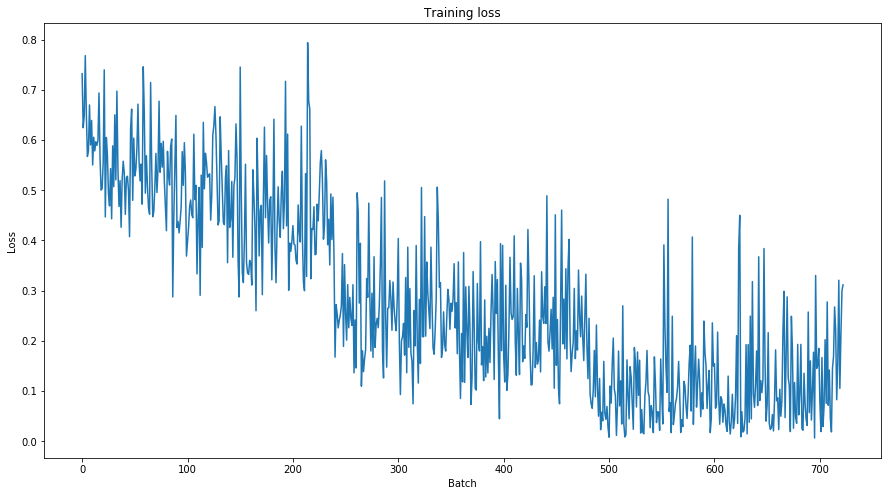

In [0]:
#Training Evaluation

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
#Predict and Evaluate

# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()

Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_zeros(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
matthews_set

[-0.14856415213808927,
 -0.21684543705982773,
 0.4107200484084535,
 0.34151450937027694,
 0.32328707534629597,
 0.6777932975034471,
 0.6831300510639732,
 0.47519096331149147,
 0.9229582069908973,
 0.7530836820370708,
 0.8459051693633014,
 0.6019292654288461,
 0.8749672939989046,
 0.7948717948717948,
 0.6637465183030647,
 0.5844155844155844,
 0.0]

In [0]:
# matthews_corrcoef(true_labels[1],np.argmax(predictions[1],axis=1).flatten())
for sublist in predictions[:1]:
  print("sublist Prediction: ",sublist)
  for item in sublist:
    print("item Prediction: ",item)
    print(np.argmax([item], axis=1).flatten())

for sublist in true_labels[:1]:
  print(sublist)
  for item in sublist:
    print(item)

sublist Prediction:  [[-0.5674768   0.56794256]
 [-2.5399373   2.3743489 ]
 [-1.7113584   1.6410048 ]
 [-2.6694741   2.524668  ]
 [-1.6496309   1.5970372 ]
 [-2.9831588   2.842339  ]
 [-1.7871261   1.6651148 ]
 [-2.4465942   2.2871761 ]
 [-2.8295798   2.7246184 ]
 [-2.4724405   2.3794801 ]
 [-1.6891097   1.609856  ]
 [-0.671418    0.66000354]
 [-1.1599834   1.1468266 ]
 [-1.8753906   1.7670336 ]
 [-1.7652073   1.6584176 ]
 [-0.5658557   0.5842044 ]
 [-2.1260583   1.9837524 ]
 [ 2.0072439  -1.6296053 ]
 [-2.2138963   2.1104698 ]
 [-2.472845    2.3228    ]
 [-2.2138963   2.1104698 ]
 [-2.0499487   1.9142171 ]
 [-1.7150785   1.621072  ]
 [-2.4544637   2.3112867 ]
 [-1.2450815   1.1934743 ]
 [-2.5823941   2.457287  ]
 [-1.9282428   1.830831  ]
 [-2.5947807   2.4931762 ]
 [-2.499322    2.4049072 ]
 [-1.6974652   1.61055   ]
 [-2.580773    2.4582474 ]
 [-0.85424966  0.8158539 ]]
item Prediction:  [-0.5674768   0.56794256]
[1]
item Prediction:  [-2.5399373  2.3743489]
[1]
item Prediction:  [-

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [0]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5572213944986825